<a href="https://colab.research.google.com/github/ashikshafi08/DUDL-Pytorch/blob/main/Optimizers_DUDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimizers - Refresher 

Develop a model that will predict the qwerties using the Optimizers. 

1. Deeplearning == alots of experiments 
2. Setting up the model in a slightly different way than before. 



In [31]:
# Importing the needed libraries 

import torch 
import torch.nn.functional as F
import torch.nn as nn 

from torch.utils.data import TensorDataset , DataLoader 
from sklearn.model_selection import train_test_split 

# For number crunching 
import numpy as np 
import scipy.stats as stats 

import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

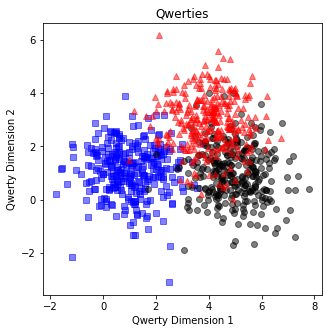

In [32]:
# Create the qwerties data 

nPerClust = 300 # 3 classes 
blur = 1 

A = [1 ,1]
B = [5 , 1]
C = [4 ,3]

# Generate the data 
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur]

# Making the truth labels 
labels_np = np.hstack((np.zeros((nPerClust)) , 
                       np.ones((nPerClust)), 
                       1+np.ones((nPerClust)) ))

# Concatenate everything into a matrix 
data_np = np.hstack((a, b , c)).T # taking the transpose of the matrix 


# Converting the data into Pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() 

# Plotting the data 
fig = plt.figure(figsize = (5 , 5))

plt.plot(data[np.where(labels == 0)[0] , 0] , data[np.where(labels == 0)[0] , 1] , 'bs' , alpha = .5)
plt.plot(data[np.where(labels == 1)[0] , 0] , data[np.where(labels == 1)[0] , 1] , 'ko' , alpha = .5)
plt.plot(data[np.where(labels == 2)[0] , 0] , data[np.where(labels == 2)[0] , 1] , 'r^' , alpha = .5)
plt.title('Qwerties')
plt.xlabel('Qwerty Dimension 1')
plt.ylabel('Qwerty Dimension 2')
plt.show()

In [33]:
# Using sklearn to split the data 
train_data , test_data , train_labels , test_labels = train_test_split(data , labels, 
                                                                       test_size =.1 )

# Converting the tensors into Pytorch Datasets 
train_data = TensorDataset(train_data , train_labels)
test_data = TensorDataset(test_data , test_labels)

# Batching the dataset 
batch_size = 16 

# Converting the Dataset into DataLoader 
train_loader = DataLoader(train_data , batch_size = batch_size , 
                        shuffle = True , drop_last = True)

test_loader = DataLoader(test_data , batch_size = test_data.tensors[0].shape[0]) # all the samples in a test data will be the batch size


In [34]:
# How many batches are there? 
# 45 batches, each with 16 samples

len(train_loader) , batch_size 

(50, 16)

In [35]:
# Create a class for the model 
def createTheQwertyNet():

  class qwertyNet(nn.Module):

    def __init__(self):
      super().__init__()

      # Input layer 
      self.input = nn.Linear(2 , 8)
      
      # Hidden layer 
      self.fc1 = nn.Linear(8 , 8)

      # Output layer 
      self.output = nn.Linear(8 ,3)

      # Creating instance of the Relu class 
      self.relu1 = nn.ReLU() # equivalent to F.relu

    # Forward pass 
    def forward(self, x):
      x = self.relu1(self.input(x))
      x = self.relu1(self.fc1(x))
      return self.output(x)

  # Crreate the model instance 
  net = qwertyNet()

  # Initializing the optimizer and loss function 
  optimizer = torch.optim.SGD(net.parameters() , lr = .01)
  loss_func = nn.CrossEntropyLoss() 


  return net , loss_func , optimizer



`F.relu` or `torch.relu` is the same, we can avoid using the F class and therefore use something like `nn.Relu` 



In [36]:
# Test the model with fake input 

net , lossf , opt = createTheQwertyNet()

# Input 10 samples 
input = torch.randn(10 ,2)
net(input)

tensor([[-0.2398, -0.0793, -0.1552],
        [-0.3289, -0.1453, -0.0679],
        [-0.2502, -0.1458, -0.0631],
        [-0.2111,  0.1045, -0.2162],
        [-0.2788, -0.0725, -0.1156],
        [-0.2523, -0.0298, -0.1519],
        [-0.3167, -0.1104, -0.0915],
        [-0.3220, -0.0357, -0.1036],
        [-0.2727, -0.0542, -0.1264],
        [-0.3951,  0.2700, -0.3946]], grad_fn=<AddmmBackward0>)

In [37]:
# Function to train the model 

def function2trainTheModel():

  # Number of epochs 
  numEpochs = 100 

  # Create a new instance of the model 
  net , loss_func , optimizer = createTheQwertyNet() 

  # Initialize the losses 
  losses = torch.zeros(numEpochs)
  trainAcc  , testAcc = [] , []

  # Loop over the epochs 
  for epoch in range(numEpochs):
    print(f'##### Epoch {epoch} ####')
    #print('\n######-------##########\n')

    # Switch on the training mode 
    net.train()

    # Loop over the training data batches 
    batchAcc , batchLoss = [] , []
    for X , y in train_loader:

      # Forward pass and computing the loss 
      yHat = net(X)
      loss = loss_func(yHat, y)

      # Backward pass 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch 
      batchLoss.append(loss.item())

      # Compute accuracy 
      matches = torch.argmax(yHat , axis = 1) == y # are they matching? (false/true)
      matchesNumeric = matches.float() # booleans into numbers 
      accuracyPct = 100*torch.mean(matchesNumeric) # calculating the accuracy
      batchAcc.append(accuracyPct)

    # end of the batch loop 

    # Get the average of the above batch loss and average 
    trainAcc.append(np.mean(batchAcc))
    losses[epoch] = np.mean(batchLoss)

    # Test accuracy 

    # Model into eval model 
    net.eval()
    X , y = next(iter(test_loader)) # extract x and y from loader 
    
    # Making predictions by deactivating the autograd
    with torch.no_grad(): 
      yHat = net(X)

    testAcc.append(100*torch.mean((torch.argmax(yHat , axis = 1) == y).float()))

  # Returning the output 
  return trainAcc , testAcc, losses , net

In [38]:
# Training the model 
trainAcc , testAcc , losses , net = function2trainTheModel()

##### Epoch 0 ####
##### Epoch 1 ####
##### Epoch 2 ####
##### Epoch 3 ####
##### Epoch 4 ####
##### Epoch 5 ####
##### Epoch 6 ####
##### Epoch 7 ####
##### Epoch 8 ####
##### Epoch 9 ####
##### Epoch 10 ####
##### Epoch 11 ####
##### Epoch 12 ####
##### Epoch 13 ####
##### Epoch 14 ####
##### Epoch 15 ####
##### Epoch 16 ####
##### Epoch 17 ####
##### Epoch 18 ####
##### Epoch 19 ####
##### Epoch 20 ####
##### Epoch 21 ####
##### Epoch 22 ####
##### Epoch 23 ####
##### Epoch 24 ####
##### Epoch 25 ####
##### Epoch 26 ####
##### Epoch 27 ####
##### Epoch 28 ####
##### Epoch 29 ####
##### Epoch 30 ####
##### Epoch 31 ####
##### Epoch 32 ####
##### Epoch 33 ####
##### Epoch 34 ####
##### Epoch 35 ####
##### Epoch 36 ####
##### Epoch 37 ####
##### Epoch 38 ####
##### Epoch 39 ####
##### Epoch 40 ####
##### Epoch 41 ####
##### Epoch 42 ####
##### Epoch 43 ####
##### Epoch 44 ####
##### Epoch 45 ####
##### Epoch 46 ####
##### Epoch 47 ####
##### Epoch 48 ####
##### Epoch 49 ####
##### Epoc

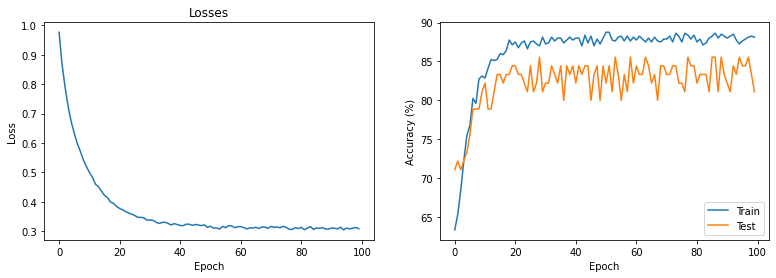

In [39]:
# Plotting the result 
fig , ax = plt.subplots(1 ,2 , figsize = (13 , 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc , label = 'Train')
ax[1].plot(testAcc , label = 'Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].legend()
plt.show()

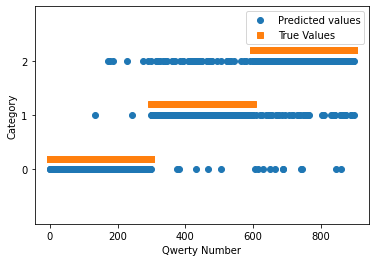

In [40]:
# Run the data through the model to get the categorical predictions 
yHat = net(data)
predictions = torch.argmax(yHat , axis = 1) # max of 3 rows 

# Plot these against the real data 
plt.plot(predictions , 'o', label = 'Predicted values')
plt.plot(labels +.2 , 's' , label = 'True Values')
plt.xlabel('Qwerty Number')
plt.ylabel('Category')
plt.yticks([0 , 1 ,2])
plt.ylim([-1 , 3])
plt.legend()
plt.show()

Above is the trained version of the model on the whole data without splitting the data into different splits. 

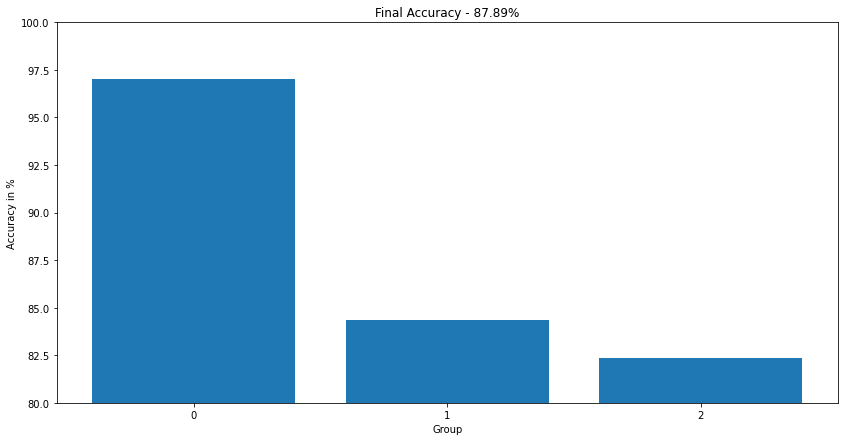

In [41]:
# Quantify the errors a bit 
accuracy = (predictions == labels).float() # vector of 1/0, where pred matches the true label (1) else 0 

# Compute the overall acc 
totalAcc = torch.mean(100*accuracy).item()

# Average by group (for different classes)
accuracyByGroup = np.zeros(3) # total 3 classes 

for i in range(3):
  accuracyByGroup[i] = 100*torch.mean(accuracy[labels == i])

# Visualizing the result per Category 
plt.figure(figsize = (14 , 7))
plt.bar(range(3) , accuracyByGroup)
plt.ylim([80 , 100])
plt.xticks([0 , 1 ,2])
plt.xlabel('Group')
plt.ylabel('Accuracy in %')
plt.title(f'Final Accuracy - {totalAcc:.2f}%')
plt.show()

## Optimizer - Refresher 

1. What optimizer is  
2. Reminder of what SGD is
3. Learn why mini-batch SGD acts as an optimizer 
4. Learn about momentum and why it improves learning. 


The idea of GD is to find the minimum of a function. So before we were applying the GD on different mathematical functions. 

In deeplearning, we represent the discrepancy / or the error landscape between the predictions and truth labels as a mathematical function / multi-dimensional error landscape. 

#### **The Goal of GD**

Is to find the minimum point on the error landscape which corresponds to the higher accuracy / the best match between what the model predicts and the truth label. 

#### **How GD Works**
- Pick a random set of weights. 
- Train those parameters / weights so we can find the best set of weights that will minimize the error. 

We get into the iterations 
  - Compute Derivatives on that point / local min / point of error function w.r.t the weights and because its a multi-dimensional function we call it as gradients, derivatives seems to be perfect for a lowerD. 
  - We need gradients because the gradients tells us whether the error function is going up or down, if its going up we multiply with a minus sign (-grad * lr) and update the gradients with a learning rate. 
  - The gradient itself seems to be much larger than the step size we want to take in the error landscape. 
  - If we are updating the gradients by subtracting with the weights (for update) then it will totally miss out the local minimum at which the error will be less. We don't want this to happen and we need our gradients to be scaling down pretty slow so it doesn't miss out the local minimum of the error function. 
  - For this scaling purpose, we use something called a learning rate instead of just subtracting the gradients we scale it by using a learning rate so now the steps will be in small size and our gradient won't be jumping around the error landscape instead of finding the local minimum. 
  - The goal of lr is to slow down the learning process so it doesn't miss out the local minimum. 

#### **How can we fit in optimizer's into this phenomenon ?**

Optimizers used to decide how exactly the gradients is scaled / how would we choose the size of the steps we will be taking. 


**Optimizers refers to the algorithm that adjusts the weights during back propagation.** 

**Other optimizers are simply the modifications of SGD, with the goal of smoothing the descent. We apply small tweaks to them.**


### Momentum with SGD 

This will be an experimentation, where we will manipulate the key parameter in the momentum that is the β parameter. 

In [42]:
# Create a class for the model 

# function takes a momentum input 
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):

    def __init__(self):
      super().__init__()

      # Input layer 
      self.input = nn.Linear(2 , 8)
      
      # Hidden layer 
      self.fc1 = nn.Linear(8 , 8)

      # Output layer 
      self.output = nn.Linear(8 ,3)

      # Creating instance of the Relu class 
      self.relu1 = nn.ReLU() # equivalent to F.relu

    # Forward pass 
    def forward(self, x):
      x = self.relu1(self.input(x))
      x = self.relu1(self.fc1(x))
      return self.output(x)

  # Crreate the model instance 
  net = qwertyNet()

  # Initializing the optimizer and tuning the momentum 
  # Default momentum set to 0, and when its 0 that means vanilla gradient descent
  optimizer = torch.optim.SGD(net.parameters() , lr = .01 , momentum = momentum)

  # loss function 
  loss_func = nn.CrossEntropyLoss() 


  return net , loss_func , optimizer


# Confirm the optimizer has momentum 
op = createTheQwertyNet(.9)[2]
op

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [43]:
# create a class for the model
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (note extra input!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

  return net,lossfun,optimizer


In [44]:
# a function that trains the model


# number of epochs
numepochs = 50


def funtion2trainTheModel(momentum):
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(momentum)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [45]:
# momentum values to use 
momenta = [0 , .5 , .9 , .95 , .999]

# Intialize the results matrix 
results = np.zeros((numEpochs , len(momenta) , 3))

#  Creating new model instance for every different momenta values 
for idx , mom in enumerate(momenta):
  trainAcc , testAcc , losses , net = funtion2trainTheModel(mom)

  # Storing the results for different models 
  results[: , idx , 0] = losses 
  results[: , idx , 1] = trainAcc 
  results[: , idx , 2] = testAcc

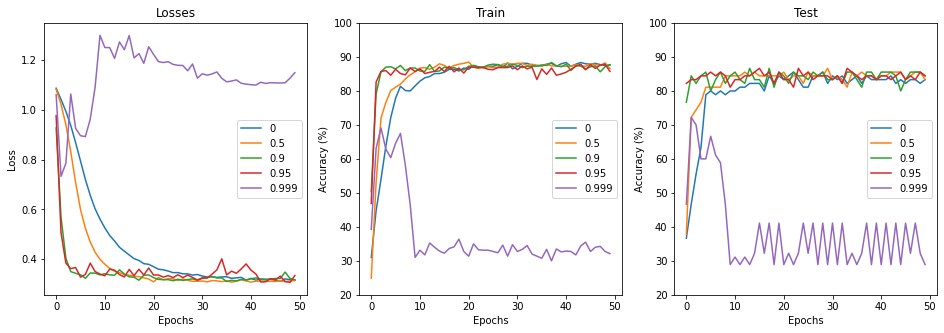

In [51]:
# Plotting the results 
fig , ax = plt.subplots(1 , 3 , figsize = (16 ,5))

# For 3 components we stores (loss , train acc and test acc)
for i in range(3):
  ax[i].plot(results[: , : , i]) # last axis 
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')

  if i == 0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20 , 100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

- With no β the results seems okayish. 
- As we increase the β value except the last one, we were getting great results. The β at certain point becomes so large we are not even learning. 